In [1]:
import yfinance as yf
from pandas_datareader import data as pdr
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
from keras.layers import Dense, LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

yf.pdr_override()

pd.options.display.max_rows = 100
pd.set_option('display.max_columns', None)

In [19]:
data = pd.read_csv('data.csv').fillna(method='ffill')

raw_X = MinMaxScaler().fit_transform(data[data.columns[-19:-3]])
raw_y = MinMaxScaler().fit_transform(data['BTC-USD'].values.reshape(len(data), 1))

In [16]:
data

,Date,SPY,GOOG,TSLA,FB,AAPL,MSFT,BTC-USD,ETH-USD,ADA-USD,XRP-USD,DOGE-USD,LTC-USD,XLM-USD,LINK-USD,total_cases,new_cases,total_deaths,new_deaths,new_tests,total_tests,positive_rate,total_vaccinations,people_vaccinated,total_cases_rate,new_cases_rate,total_deaths_rate
0,2020-01-22,322.114716,1485.949951,113.912003,221.320007,78.262489,162.897568,8680.875977,168.294159,0.045654,0.236056,0.002323,58.354725,0.059889,2.645582,1.0,0.0,0.0,0.0,0.0,0.0,0.000,0.0,0.0,3.003769e-09,0.000000e+00,0.000000
1,2020-01-23,322.484192,1486.650024,114.440002,219.759995,78.639381,163.900330,8406.515625,162.928558,0.043334,0.226104,0.002268,54.630260,0.059238,2.462109,1.0,0.0,0.0,0.0,0.0,0.0,0.000,0.0,0.0,3.003769e-09,0.000000e+00,0.000000
2,2020-01-24,319.616272,1466.709961,112.963997,217.940002,78.412750,162.248703,8445.434570,163.051178,0.045004,0.223041,0.002276,54.531788,0.057303,2.504390,2.0,1.0,0.0,0.0,0.0,0.0,0.000,0.0,0.0,6.007538e-09,3.003769e-09,0.000000
3,2020-01-25,319.616272,1466.709961,112.963997,217.940002,78.412750,162.248703,8367.847656,161.283936,0.043248,0.220427,0.002257,53.697788,0.056039,2.456526,2.0,0.0,0.0,0.0,0.0,0.0,0.000,0.0,0.0,6.007538e-09,0.000000e+00,0.000000
4,2020-01-26,319.616272,1466.709961,112.963997,217.940002,78.412750,162.248703,8596.830078,168.077103,0.044581,0.230686,0.002305,56.212715,0.058572,2.571582,5.0,3.0,0.0,0.0,0.0,0.0,0.000,0.0,0.0,1.501885e-08,9.011307e-09,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
660,2021-11-12,467.269989,2992.909912,1033.420044,340.890015,149.990005,336.720001,64155.941406,4667.115234,2.045766,1.189355,0.259414,251.558365,0.379479,34.265522,47007119.0,140400.0,762520.0,2483.0,733070.0,642687108.0,0.078,442106031.0,227149368.0,1.411985e-01,4.217292e-04,0.002290
661,2021-11-13,467.269989,2992.909912,1033.420044,340.890015,149.990005,336.720001,64469.527344,4651.460449,2.053104,1.191938,0.261706,258.093201,0.378916,34.064831,47054618.0,47499.0,762972.0,452.0,0.0,0.0,0.000,443009805.0,227545172.0,1.413412e-01,1.426760e-04,0.002292
662,2021-11-14,467.269989,2992.909912,1033.420044,340.890015,149.990005,336.720001,65466.839844,4626.358887,2.040853,1.188597,0.262912,278.007507,0.377429,33.776585,47079428.0,24810.0,763092.0,120.0,0.0,0.0,0.000,443281184.0,227663683.0,1.414157e-01,7.452351e-05,0.002292
663,2021-11-15,467.429993,2987.760010,1013.390015,347.559998,150.000000,336.070007,63557.871094,4557.503906,2.015587,1.171371,0.256529,262.763397,0.375941,32.010754,47221527.0,142099.0,764363.0,1271.0,0.0,0.0,0.000,443374199.0,227691941.0,1.418426e-01,4.268326e-04,0.002296


In [17]:
data.columns[-19:-3]

Index(['ETH-USD', 'ADA-USD', 'XRP-USD', 'DOGE-USD', 'LTC-USD', 'XLM-USD',
       'LINK-USD', 'total_cases', 'new_cases', 'total_deaths', 'new_deaths',
       'new_tests', 'total_tests', 'positive_rate', 'total_vaccinations',
       'people_vaccinated'],
      dtype='object')

In [20]:
X = np.array([raw_X[i-90:i] for i in range(90, 665)])
y = raw_y[90:]

X.shape, y.shape

((575, 90, 16), (575, 1))

In [21]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.33, random_state=12345)

In [22]:
model = tf.keras.Sequential()
model.add(LSTM(units=32, return_sequences=True,
                  input_shape=(90,16), dropout=0.2))
model.add(LSTM(units=32, return_sequences=True,
                  dropout=0.2))
model.add(LSTM(units=32, dropout=0.2))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 90, 32)            6272      
_________________________________________________________________
lstm_4 (LSTM)                (None, 90, 32)            8320      
_________________________________________________________________
lstm_5 (LSTM)                (None, 32)                8320      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 33        
Total params: 22,945
Trainable params: 22,945
Non-trainable params: 0
_________________________________________________________________


In [23]:
model.compile(optimizer='adam', loss='mean_squared_error')
history = model.fit(X, y, epochs=30, batch_size=32)

Epoch 1/30
18/18 [==============================] - 5s 50ms/step - loss: 0.0682
Epoch 2/30
18/18 [==============================] - 1s 49ms/step - loss: 0.0231
Epoch 3/30
18/18 [==============================] - 1s 50ms/step - loss: 0.0133
Epoch 4/30
18/18 [==============================] - 1s 45ms/step - loss: 0.0102
Epoch 5/30
18/18 [==============================] - 1s 46ms/step - loss: 0.0083
Epoch 6/30
18/18 [==============================] - 1s 46ms/step - loss: 0.0072
Epoch 7/30
18/18 [==============================] - 1s 47ms/step - loss: 0.0072
Epoch 8/30
18/18 [==============================] - 1s 47ms/step - loss: 0.0058
Epoch 9/30
18/18 [==============================] - 1s 48ms/step - loss: 0.0046
Epoch 10/30
18/18 [==============================] - 1s 48ms/step - loss: 0.0049
Epoch 11/30
18/18 [==============================] - 1s 47ms/step - loss: 0.0045
Epoch 12/30
18/18 [==============================] - 1s 49ms/step - loss: 0.0048
Epoch 13/30
18/18 [==================

In [24]:
pred = model.predict(X)

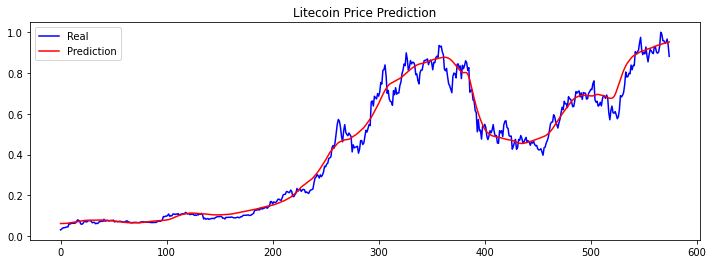

In [25]:
plt.figure(figsize=(12,4))
plt.plot(y, color='blue', label='Real')
plt.plot(pred, color='red', label='Prediction')
plt.title('Litecoin Price Prediction')
plt.legend()
plt.show()